In [1]:
import numpy as np
import pandas as pd
import nltk
import sklearn as sk
import re # regex
import matplotlib

import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#load datasets
news_df = pd.read_csv('../datasets/news-20k-comments.csv')
politics_df = pd.read_csv("../datasets/politics-20k-comments.csv")
politicaldiscussion_df = pd.read_csv('../datasets/politicaldiscussion-20k-comments.csv')

news_df = news_df.filter(['created_utc', 'body'])
politics_df = politics_df.filter(['created_utc', 'body'])
politicaldiscussion_df = politicaldiscussion_df.filter(['created_utc', 'body'])

In [3]:
#filter out deleted comments
news_df = news_df[news_df['body'] != "[deleted]"]
politics_df = politics_df[politics_df['body'] != "[deleted]"]
politicaldiscussion_df = politicaldiscussion_df[politicaldiscussion_df['body'] != "[deleted]"]

In [4]:
# clean out any urls and and brackets, parenthesis and hyphens, leaving only alphanumeric words
url_regex = r"([--:\w?@%&+~#=]*\.[a-z]{2,4}\/{0,2})((?:[?&](?:\w+)=(?:\w+))+|[--:\w?@%&+~#=]+)?"
special_character_regex = r"[\"'()[\]]"

news_df['body'] = news_df['body'].astype('str')
politics_df['body'] = politics_df['body'].astype('str')
politicaldiscussion_df['body'] = politicaldiscussion_df['body'].astype('str')

#remove urls, special characters, and replace hyphens with a space
news_df['clean'] = news_df['body'].apply(lambda text: text.strip().lower()).apply(lambda text: re.sub(url_regex, '', text)).apply(lambda text: re.sub(special_character_regex, '', text)).apply(lambda text: re.sub(r"-", ' ', text))
politics_df['clean'] = politics_df['body'].apply(lambda text: text.strip().lower()).apply(lambda text: re.sub(url_regex, '', text)).apply(lambda text: re.sub(special_character_regex, '', text)).apply(lambda text: re.sub(r"-", ' ', text))
politicaldiscussion_df['clean'] = politicaldiscussion_df['body'].apply(lambda text: text.strip().lower()).apply(lambda text: re.sub(url_regex, '', text)).apply(lambda text: re.sub(special_character_regex, '', text)).apply(lambda text: re.sub(r"-", ' ', text))

In [5]:
#tokenize
news_df['tokens'] = news_df['clean'].apply(lambda text: re.sub(r"[.,!?]"," ", text)).apply(lambda text: re.sub(r"[0-9]", " ", text)).apply(nltk.wordpunct_tokenize)
politics_df['tokens'] = politics_df['clean'].apply(lambda text: re.sub(r"[.,!?]"," ", text)).apply(lambda text: re.sub(r"[0-9]", " ", text)).apply(nltk.wordpunct_tokenize)
politicaldiscussion_df['tokens'] = politicaldiscussion_df['clean'].apply(lambda text: re.sub(r"[.,!?]"," ", text)).apply(lambda text: re.sub(r"[0-9]", " ", text)).apply(nltk.wordpunct_tokenize)

In [6]:
news_df = news_df.reset_index(drop=True)
politics_df = politics_df.reset_index(drop=True)
politicaldiscussion_df = politicaldiscussion_df.reset_index(drop=True)
print(len(news_df), "total comments from r/news")
print(len(politics_df), "total comments from r/politics")
print(len(politicaldiscussion_df), "total comments from r/PoliticalDiscussion")

17536 total comments from r/news
18857 total comments from r/politics
19174 total comments from r/PoliticalDiscussion


In [164]:
all_df = pd.concat([news_df, politics_df, politicaldiscussion_df]) # merge all three subreddit datas

In [165]:
# build the test samples for evals
# since we trained using 80% of the total comments, we test on 20% of them.

import nltk

boundary = int(len(news_df)*0.8) #80/20 train/test split
news_df_test = news_df[boundary:]

boundary = int(len(politics_df)*0.8) #80/20 train/test split
politics_df_test = politics_df[boundary:]

boundary = int(len(politicaldiscussion_df)*0.8) #80/20 train/test split
politicaldiscussion_df_test = politicaldiscussion_df[boundary:]

news_test_vocab = nltk.lm.Vocabulary([word for sent in news_df_test['tokens'] for word in sent])
politics_test_vocab = nltk.lm.Vocabulary([word for sent in politics_df_test['tokens'] for word in sent])
politicaldiscussion_test_vocab = nltk.lm.Vocabulary([word for sent in politicaldiscussion_df_test['tokens'] for word in sent])
test_vocab = nltk.lm.Vocabulary([word for sent in all_df['tokens'] for word in sent])

In [8]:
def preprocess(tokenizer, texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, len(tokenizer.word_index))

def generate_char(model, tokenizer, text, temperature=1):
    X_new = preprocess(tokenizer, [text])
    Y_pred = model.predict(X_new)[0, -1:, :]
    rescaled = tf.math.log(Y_pred)/temperature
    char_id = tf.random.categorical(rescaled, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

def generate(model, tokenizer, text, n=50, temperature=1):
    for _ in range(n):
        text += generate_char(model, tokenizer, text, temperature)
    return text

In [9]:
import random
def random_char():
    return random.choice(list('abcdefghijklmnopqrstuvwxyz'))

random_char()

'r'

In [10]:
#make tokenizers for each of the models
news_all_text = ""
for comment in news_df['clean']:
    news_all_text += "<" + comment + ">"
    
politics_all_text = ""
for comment in politics_df['clean']:
    politics_all_text += "<" + comment + ">"
    
political_discussion_all_text = ""
for comment in politicaldiscussion_df['clean']:
    political_discussion_all_text += "<" + comment + ">"
    
news_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
news_tokenizer.fit_on_texts(news_all_text)

politics_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
politics_tokenizer.fit_on_texts(politics_all_text)

political_discussion_tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
political_discussion_tokenizer.fit_on_texts(political_discussion_all_text)

In [11]:
# load models
news_model = keras.models.load_model('saved_models/NEWS_RNN_2_GRU_128_SOFTMAX_03_DROPOUT_EARLY_STOPPING', compile=False)
politics_model = keras.models.load_model('saved_models/POLITICS_RNN_2_GRU_128_SOFTMAX_03_DROPOUT_EARLY_STOPPING', compile=False)
political_discussion_model = keras.models.load_model('saved_models/POLDIS_RNN_2_GRU_128_SOFTMAX_03_DROPOUT_EARLY_STOPPING/', compile=False)

In [12]:
print("Fake sentence from r/news:\n", generate(news_model, news_tokenizer, random_char(), n=100, temperature=0.2),"\n")
print("Fake sentence from r/politics:\n", generate(politics_model, politics_tokenizer, random_char(), n=100, temperature=0.2),"\n")
print("Fake sentence from r/PoliticalDiscussion:\n", generate(political_discussion_model, political_discussion_tokenizer, random_char(), n=100, temperature=0.2),"\n")

Fake sentence from r/news:
 he really the rich and they werent problem with the right to the same than they werent problem with t 

Fake sentence from r/politics:
 ke is the people with a socialist the possible with a conservative is the same thing and some time is 

Fake sentence from r/PoliticalDiscussion:
 zens that be a sense that the fact of the problem is that the country was a serious with more of the  



In [93]:
len(news_test_vocab)

9493

In [167]:
all_words = [token for sentence in all_df['tokens'] for token in sentence]

freqdist = nltk.FreqDist(all_words)
freqdist

unique_words = []
for word in all_words:
    if word not in unique_words:
        unique_words.append(word)

print("Total words: ", len(all_words))
print("Unique words: ", len(unique_words))
print("Words that only occur once: ", len([word for word in all_words if freqdist[word] == 1]))

Total words:  2853399
Unique words:  39777
Words that only occur once:  14367


In [166]:
def perplexity(vocab):
    #perplexity is 2^entropy
    entropy = -1 * np.array([np.log(1/vocab[word]) for word in vocab.counts]).mean()
    return np.e ** entropy

print("Perplexities of test vocabularies")
print("==============================")
print("r/news:", perplexity(news_test_vocab))
print("r/politics:", perplexity(politics_test_vocab))
print("r/PoliticalDiscussion:", perplexity(politicaldiscussion_test_vocab))
print("Whole:", perplexity(test_vocab))

Perplexities of test vocabularies
r/news: 2.7179962127382726
r/politics: 2.764990642771706
r/PoliticalDiscussion: 3.1606773869653226
Whole: 4.386876986090843


In [131]:
#losses from tensorflow logs
news_loss = 1.769
politics_loss = 1.49
political_discussion_loss = 1.71
print("Perplexities of models")
print("==============================")
print("r/news:", np.e  ** news_loss)
print("r/politics:", np.e  ** politics_loss)
print("r/PoliticalDiscussion:", np.e  ** political_discussion_loss)

Perplexities of models
r/news: 5.864985442469667
r/politics: 4.437095519003664
r/PoliticalDiscussion: 5.528961477624003


In [132]:
# sentiment analysis

from transformers import pipeline
classifier = pipeline('sentiment-analysis')

In [153]:
#random selection of 500 sentences from each subreddit
#BERT only allows for 512 tokens for embeddings
news_sentiments = classifier(list(news_df[news_df['clean'].str.len() < 512]['clean'].sample(500)))
politics_sentiments = classifier(list(politics_df[politics_df['clean'].str.len() < 512]['clean'].sample(500)))
politicaldiscussion_sentiments = classifier(list(politicaldiscussion_df[politicaldiscussion_df['clean'].str.len() < 512]['clean'].sample(500)))

In [154]:
news_adjusted_sentiments = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in news_sentiments])

politics_adjusted_sentiments = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in politics_sentiments])

politicaldiscussion_adjusted_sentiments = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in politicaldiscussion_sentiments])

In [155]:
news_avg_sentiment = news_adjusted_sentiments.mean()
politics_avg_sentiment = politics_adjusted_sentiments.mean()
politicaldiscussion_sentiment = politicaldiscussion_adjusted_sentiments.mean()

In [158]:
#ngenerated sentences
news_generated = []
for i in range(200):
    news_generated.append(generate(news_model, news_tokenizer, random_char(), n=100, temperature=0.3))
    
politics_generated = []
for i in range(200):
    politics_generated.append(generate(politics_model, politics_tokenizer, random_char(), n=100, temperature=0.3))
    
political_discussion_generated = []
for i in range(200):
    political_discussion_generated.append(generate(political_discussion_model, political_discussion_tokenizer, random_char(), n=100, temperature=0.3))

In [161]:
news_generated_sentiments = classifier(news_generated)
news_generated_avg_sentiment = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in news_generated_sentiments]).mean()

politics_generated_sentiments = classifier(politics_generated)
politics_generated_avg_sentiment = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in politics_generated_sentiments]).mean()

political_discussion_generated_sentiments = classifier(political_discussion_generated)
political_discussion_generated_avg_sentiment = np.array([result['score'] * 1 if result['label'] == "POSITIVE" else result['score'] * -1 for result in political_discussion_generated_sentiments]).mean()

In [162]:
print("Average Sentiments for Subreddits")
("==============================")
print("r/news:", news_avg_sentiment)
print("r/politics:", politics_avg_sentiment)
print("r/PoliticalDiscussion:", politicaldiscussion_sentiment)
print("\nIs this really surprising?")

Average Sentiments for Subreddits
r/news: -0.6204939737319947
r/politics: -0.4521908963918686
r/PoliticalDiscussion: -0.46540864324569703

Is this really surprising?


In [163]:
print("Average Sentiments for Generated Sentences")
("==============================")
print("r/news:", news_generated_avg_sentiment)
print("r/politics:", politics_generated_avg_sentiment)
print("r/PoliticalDiscussion:", political_discussion_generated_avg_sentiment)

Average Sentiments for Generated Sentences
r/news: -0.6637715741991996
r/politics: -0.5380840355157852
r/PoliticalDiscussion: -0.842566411793232


In [104]:
import seaborn as sns
sns.set_theme()
%matplotlib inline

In [113]:
perplexity_df = pd.DataFrame([["Baseline", 11.679503125466205], ["",0], ["r/news", 5.864985442469667],["r/politics", 4.437095519003664],["r/PolitialDiscussion", 5.528961477624003]], columns=["Model", "Perplexity"])
perplexity_df

,Model,Perplexity
0,Baseline,11.679503
1,,0.000000
2,r/news,5.864985
3,r/politics,4.437096
4,r/PolitialDiscussion,5.528961


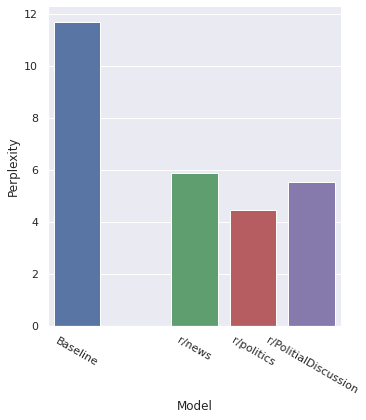

In [128]:
plot = sns.catplot(x="Model", y="Perplexity", kind="bar", data=perplexity_df)
plot.set_xticklabels(rotation=-30)
plot.savefig('perplexity.png', dpi=150)

In [143]:
def evaluate_precision(generated_sents, vocab):
    generated_tokens = [token for sent in generated_sents for token in sent.split()]
    true_positive = 0
    false_positive = 0
    for word in generated_tokens:
        if word in vocab:
            true_positive += 1
        else:
            false_positive += 1
    
    return true_positive / (true_positive + false_positive)

In [147]:
print("Precisions")
print("============================")
print("r/news:", evaluate_precision(news_generated, news_test_vocab))
print("r/politics:", evaluate_precision(politics_generated, politics_test_vocab))
print("r/PoliticalDiscussion:", evaluate_precision(political_discussion_generated, politicaldiscussion_test_vocab))

Precisions
r/news: 0.9599271402550091
r/politics: 0.9532530120481928
r/PoliticalDiscussion: 0.9444967074317968


In [151]:
precisions_df = pd.DataFrame([["Baseline", 0.8825503355704698], ["",0], ["r/news", 0.9599271402550091],["r/politics", 0.9532530120481928],["r/PolitialDiscussion", 0.9444967074317968]], columns=["Model", "Precision"])
precisions_df

,Model,Precision
0,Baseline,0.882550
1,,0.000000
2,r/news,0.959927
3,r/politics,0.953253
4,r/PolitialDiscussion,0.944497


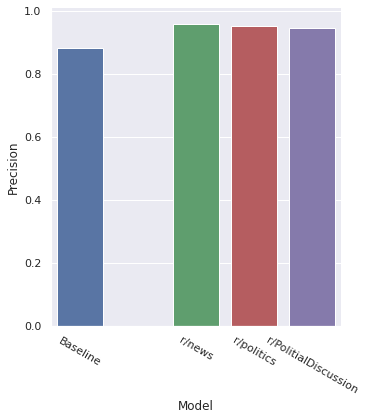

In [152]:
plot = sns.catplot(x="Model", y="Precision", kind="bar", data=precisions_df)
plot.set_xticklabels(rotation=-30)
plot.savefig('precision.png', dpi=150)

In [168]:
politics_generated[:5]

['ve that is that is the same thing and the american people with the subject of the bush since the amer',
 'e is the fure commanity. they let the bush in the person with the same thing that was a same and more',
 'just believe the big police and way in the subject of the senator in the system.  i dont let my mane ',
 'out for a state and comparison and dont let money to come the people would be a fair as a senator is ',
 'can candidate with the subject of the american people with a conservative with him and why i make a s']

In [169]:
news_generated[:5]

['ze what the cops do not really mean it is the right of a point of the police are going to do anything',
 'ze where they werent the riots were recently the reason a problem is a cop of the station and the dog',
 'country to come of the right to the cops are arrested with the police are the rest of the station of ',
 'e are the way they werent simply the station of the same states and the cops in the situation in the ',
 'm a rich the police are the station about the police are true. \n\nthey werent problem with the rich an']

In [171]:
political_discussion_generated[:5]

['ugh the conservative company of the same of the work of the same than the majority of the problem tha',
 'ctions will control in the fact of the throat of the world and the senate of the oricion of the probl',
 'control of the work for the true program without a control of the world in the same thing that they w',
 'x a some of the country before the iraqi state of the sentral states that state is the last of the se',
 'e the fact of the same that the last of the result of the democratic problem is that the green presid']